In [1]:
#https://www.kaggle.com/piotrstanczyk/gfootball-template-bot  G-FOOTBALL TEMPLATE BOT
# Install:
# Kaggle environments.
#!git clone https://github.com/Kaggle/kaggle-environments.git
#!cd kaggle-environments && pip install .

# GFootball environment.
!apt-get update -y
!apt-get install -y libsdl2-gfx-dev libsdl2-ttf-dev

# Make sure that the Branch in git clone and in wget call matches !!
!git clone -b v5 https://github.com/Georgemouts/football.git #https://github.com/google-research/football.git  
!mkdir -p football/third_party/gfootball_engine/lib

!wget https://storage.googleapis.com/gfootball/prebuilt_gameplayfootball_v2.8.so -O football/third_party/gfootball_engine/lib/prebuilt_gameplayfootball.so
!cd football && GFOOTBALL_USE_PREBUILT_SO=1 pip3 install .

!pip install utils
#!pip install learning

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:14 http://security.ubuntu.c

In [2]:
#from gfootball.env.football_env import FootballEnv
#from kaggle_environments import make
from gfootball.env.config import Config
import gfootball.env as football_env

#import dqn libraries
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import numpy as np
import pandas as pd
import itertools
import utils
import random
from collections import deque
import matplotlib.pyplot as plt
#from utils import plot_learning_curve
#import env 
import gym
import gfootball 
import math


In [3]:
env = football_env.create_environment(env_name ='academy_empty_goal',render=False,representation='simple115v2')

new_observation,reward,done,info = env.step(5)
print(new_observation)

[ 1.49917090e-04  2.36252910e-11  1.31892890e-03  1.14766755e-11
  1.99999996e-02 -0.00000000e+00  1.10597342e-01 -0.00000000e+00
  0.00000000e+00 -1.91829144e-03]


In [4]:
class DeepQNetwork(nn.Module):
  def __init__(self,lr,input_dims,fc1_dims,fc2_dims,n_actions):
    super(DeepQNetwork,self).__init__()
   # self.lr=lr
    self.input_dims=input_dims
    self.fc1_dims=fc1_dims
    self.fc2_dims=fc2_dims
    
    self.n_actions=n_actions
    
    self.fc1=nn.Linear(*self.input_dims,self.fc1_dims) #pass list of observations as input
    self.fc2=nn.Linear(self.fc1_dims,self.fc2_dims)
    self.fc3=nn.Linear(self.fc2_dims,self.n_actions)
    #self.fc4=nn.Linear(self.fc3_dims,self.n_actions) #output number action

    self.optimizer = optim.Adam(self.parameters(),lr=lr)
    self.loss=nn.MSELoss()
    self.device =T.device('cuda:0' if T.cuda.is_available() else 'cpu' )
    self.to(self.device)

  def forward(self,state):
   
    x=F.relu(self.fc1(state))
    x=F.relu(self.fc2(x))
    actions=self.fc3(x)
    #x=F.relu(self.fc3(x))
    return actions


In [5]:
class All_prints():
  
  def __init___(self,step):
    self.step=step
    #self.RewBuffer = RewBuffer
    self.reward=reward

  def printstats(self,step,rew_list,eps_reward,epsilon):  #Kaleitai otan ginei done , diladi otan teleiosei ena paixnidi
    self.step=step
    self.rew_list=rew_list
    self.eps_reward=eps_reward
    self.epsilon=epsilon
    print("-->Episode:",i%3000 + 1,"\t","Episode Reward:",eps_reward,"\t Epsilon",agent.epsilon,"<--")
    #print("Step",step)
    print("lista apo rewards mexri tora" ,self.rew_list)
    print("Avg reward", np.mean(self.rew_list))
    print("---------------------------------------------------")

  def print_who_scored(self, reward):
    self.reward=reward
    if(self.reward==1):
      print("our team scored !!!")
    elif(self.reward ==-1):
      print("opponent team scored")
    
    
 
  def rew_graph(self,rew_list,num_of_eps):
      self.rew_list=rew_list
      
      self.num_of_eps=num_of_eps
      
      eps_list=list(range(1,self.num_of_eps+1))#pairnei to proto , den pairnei to teleytaio
      
      plt.plot(eps_list,self.rew_list)
      plt.xlabel('Episode')
      plt.ylabel('Rewards')
      plt.grid(True)
      plt.show()

  def step_graph(self,step_list,num_of_eps):
      self.step_list=step_list
      
      self.num_of_eps=num_of_eps
      
      eps_list=list(range(1,self.num_of_eps+1))#pairnei to proto , den pairnei to teleytaio
      
      plt.plot(eps_list,self.step_list)
      plt.xlabel('Episodes')
      plt.ylabel('Steps_to_score')
      plt.grid(True)
      plt.show()


  def score_graph(self,score_list,num_of_eps):
      self.score_list=score_list
      
      self.num_of_eps=num_of_eps
      
      eps_list=list(range(1,self.num_of_eps+1))#pairnei to proto , den pairnei to teleytaio
      
      plt.plot(eps_list,self.score_list)
      plt.xlabel('Episode')
      plt.ylabel('Score')
      plt.grid(True)
      plt.show()

In [6]:
class Agent():
  def __init__(self,gamma,epsilon, lr , input_dims , batch_size ,n_actions, max_mem_size = 10000  , eps_end=0.01 , eps_dec = 5e-4):
    self.gamma=gamma
    self.epsilon =epsilon
    self.lr=lr
    self.eps_min=eps_end
    self.eps_dec=eps_dec
   
    self.action_space =[i for i in range(n_actions)]
    self.mem_size = max_mem_size
    self.batch_size = batch_size
    #self.n_actions=n_actions
    self.mem_cntr =0 # keep track of the position of first available memory 

    self.Q_eval = DeepQNetwork(self.lr,n_actions=n_actions,input_dims= input_dims, fc1_dims=123, fc2_dims=123)

    self.state_memory = np.zeros((self.mem_size,*input_dims),dtype =np.float32)
    self.new_state_memory= np.zeros((self.mem_size , *input_dims),dtype=np.float32)

    self.action_memory=np.zeros(self.mem_size , dtype=np.int32) #discrete actions 
    self.reward_memory=np.zeros(self.mem_size,dtype= np.float32)
    self.terminal_memory= np.zeros(self.mem_size,dtype=bool)


  def store_transition(self,state,action,reward,new_state , done ):
    index = self.mem_cntr% self.mem_size

    self.state_memory[index]= state
    self.new_state_memory[index]= new_state
    self.reward_memory[index]= reward
    self.action_memory[index]= action  #which action is taken 
    self.terminal_memory[index]= done

    self.mem_cntr +=1
    

  def choose_action(self,observation):
    if np.random.random()> self.epsilon:
      
      state =T.tensor([observation]).to(self.Q_eval.device) #turn observation to tensor and send it to device for computations
      action_list = self.Q_eval.forward(state) #returns the values of each action
      action = T.argmax(action_list).item()
      #print("exploit:",action)
    else:     #
      
      action = np.random.choice(self.action_space)
      #print("explore:",action)
    return action

  def learn(self):    #fill batch size then learn 
    if self.mem_cntr < self.batch_size :
     
      return
    
    
    self.Q_eval.optimizer.zero_grad()

    #calculate the position of max memory / extract subset of max memories
    max_mem =min(self.mem_cntr , self.mem_size)
    


    batch=np.random.choice(max_mem,self.batch_size,replace=False) #We dont keep selecting the same memories more than once
     
    #batch = np.random.permutation(max_mem)[:self.batch_size]
    #mem = np.array(exp_buffer)[perm_batch]

    #batch=np.random.choice(max_mem,self.batch_size,replace=False)
    batch_index = np.arange(self.batch_size , dtype=np.int32)

    state_batch=T.tensor(self.state_memory[batch]).to(self.Q_eval.device) #make numpy array a pytorch tensor
    new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
    reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
    terminal_batch= T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

    action_batch = self.action_memory[batch] 
  
    q_eval = self.Q_eval.forward(state_batch)[batch_index,action_batch] #EXEI THEMA
    q_next = self.Q_eval.forward(new_state_batch)

    q_next[terminal_batch] = 0.0
    q_target = reward_batch +self.gamma * T.max(q_next,dim=1)[0] #max value of next state

    loss = self.Q_eval.loss(q_target,q_eval).to(self.Q_eval.device)
    loss.backward()
    self.Q_eval.optimizer.step()

    self.epsilon = self.epsilon - self.eps_dec if (self.epsilon > self.eps_min)  else self.eps_min
   

shout entos periohis Ball Position 0.6748292 0.07482676 0.11769817 episode 0 step= 97
goal episode 0 step= 111
---Avg reward last: 23.145269475521676 Avg score last 1.0 Avg steps 112.0 episode= 0 ---
shout entos periohis Ball Position 0.6606701 0.0063358545 0.11030549 episode 1 step= 98
goal episode 1 step= 110
shout entos periohis Ball Position 0.66584533 0.030914234 0.109984435 episode 2 step= 102
goal episode 2 step= 114
shout entos periohis Ball Position 0.67987794 0.06824194 0.11412025 episode 3 step= 110
ball is out -10 episode 3 Ball Position 1.0149277 0.05753751 0.10973845 step= 123
shout entos periohis Ball Position 0.65641165 -0.18744741 0.1148098 episode 4 step= 101
ball is out -10 episode 4 Ball Position 0.99901396 -0.1267945 0.29958403 step= 114
shout entos periohis Ball Position 0.67258954 -0.02396843 0.10939137 episode 5 step= 107
goal episode 5 step= 119
shout entos periohis Ball Position 0.663858 0.011925768 0.110295296 episode 6 step= 104
goal episode 6 step= 114
shou

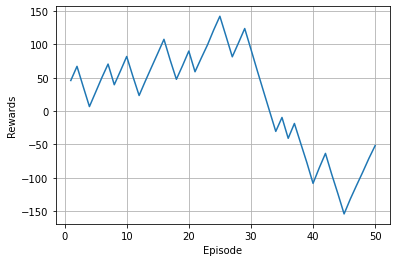

shout entos periohis Ball Position 0.74491423 0.06536207 0.12521093 episode 51 step= 121
goal episode 51 step= 130
goal episode 52 step= 163
goal episode 53 step= 164
goal episode 54 step= 160
goal episode 55 step= 152
goal episode 56 step= 155
goal episode 57 step= 151
shout entos periohis Ball Position 0.87191725 -0.0030281467 0.12912042 episode 58 step= 135
goal episode 58 step= 141
goal episode 59 step= 184
goal episode 60 step= 151
---Avg reward last: 59.192794642894796 Avg score last 1.0 Avg steps 156.1 episode= 60 ---
goal episode 61 step= 145
goal episode 62 step= 154
goal episode 63 step= 153
goal episode 64 step= 153
goal episode 65 step= 153
goal episode 66 step= 142
goal episode 67 step= 149
goal episode 68 step= 154
ball is out -10 episode 69 Ball Position 1.0158434 0.056388635 0.12866142 step= 154
goal episode 70 step= 145
---Avg reward last: 258.5048047754989 Avg score last 0.9 Avg steps 151.2 episode= 70 ---
goal episode 71 step= 149
goal episode 72 step= 157
goal episo

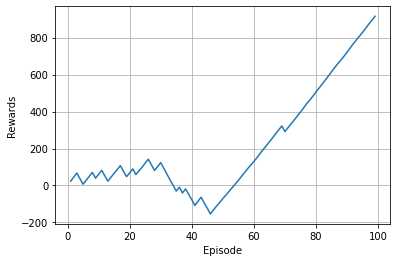

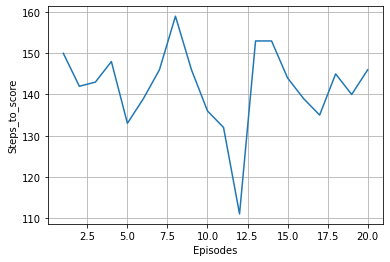

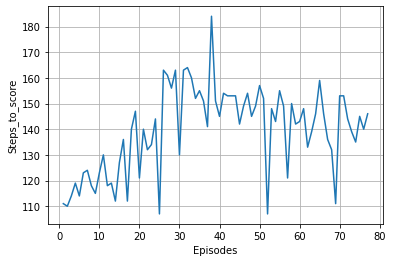

In [11]:
 
env = football_env.create_environment(env_name ='academy_empty_goal',render=False,representation='simple115v2')  #List with the 115 states 


#CUSTOMIZE ACTION LIST AND OBSERVATIONS
Action_list=[4,5,6,12]

#Create Objects

agent = Agent(gamma=0.99,epsilon=1.0 ,batch_size = 64 ,lr=0.00115 ,input_dims= [10], n_actions = len(Action_list) )# batch = best 256
all_prints = All_prints()
#cus_rew =Custom_Rewards()

scores,ep_history =[],[]

steps=0
terminal =0
episode =0
shout =0


num_of_eps = 801
eps_rew=0
rew_list =[]
score_list = []
step_list =[]
goal_steps=[]
for i in range(num_of_eps) : 
  score =0 
  done=False 
  observation =env.reset()
  act =0 #first action will be to move right 
  shout=0 #mporei na kanei shout 1 fora se kathe ep
  while not done:

    #CUSTOMIZE ACTIONS HERE 
    #An einai i mpala sto 0.5 kai exo katoxi kane shout diladi action 12
    
    #print("------------")
    #print("Ball X-Y-Z Axis",observation[88],observation[89],observation[90],"||","direct",observation[91],observation[92],observation[93],"Katoxi",observation[95],observation[96])
    #print("Player X-Axis Y-Axis",observation[2],observation[3] ,"episode",i) SOSTO
    #print("------------")



   
     
      
 
    if(act ==0 ): # proti praksi ena bima deksia
      
      # print("action 5",Action_list[action])
      new_observation,reward,done,info = env.step(5)
      
      act=1
      #print(new_observation)
    #print("Sto Else",observation[94],observation[95],observation[96])
    

    #CUSTOM ACTIONS
    action = agent.choose_action(observation) # from 1-4 which is index to action list

    while((observation[0]<0.65)  and (Action_list[action]==12)): #Den kanei shout ektos periohis
      action = agent.choose_action(observation)
     
      #print("Player Position:",observation[0],observation[1])
      #print("Player Direction:",observation[2],observation[3])
      #print("Ball Position:",observation[4],observation[5],observation[6])
      #print("Ball Direction:",observation[7],observation[8],observation[9])

    if(shout==0):   #ama kanei shout na min kanei tipota meta 
      new_observation,reward,done,info = env.step(Action_list[action])
      
      if(Action_list[action]==12):
        #print("EKANE SHOUT")
        shout=1
    else:
      #print("MPIKE STO ELSE")
      new_observation,reward,done,info = env.step(0)
      action=0 #Ta parakato if den pianoun to Action_list[action]=12 alla gia Action_list[action]=4

   
    
    
    #CUSTOM REWARDS
    
    if(done ==1 and reward != 1): #if ball is out ,loses -2
      #print("Ball is out reward:",reward)
      reward = reward -10 #12
      print("ball is out -10","episode",i,"Ball Position",observation[4],observation[5],observation[6],"step=",steps)
      terminal =0


    if(reward==1 and  done ==1): #if agent scores , wins +5
      print("goal","episode",i,"step=",steps)
      reward += 40 #35


      terminal= terminal +1
      goal_steps.append(steps)

    if((observation[0]<0.5)  and (Action_list[action]==12)): #an shoutarei prin th megali perioxh -2
      
      reward= reward -200
      done=1
      print("shout ektos periohis","episode",i,"step=",steps)
      
    if((observation[0]>0.6) and (Action_list[action]==12)): #an shoutarei mesa ti megali periohi +0.1
      #reward= reward +0.1
      print("shout entos periohis Ball Position",observation[4],observation[5],observation[6],"episode",i,"step=",steps)
      
    
    reward = reward - ( math.sqrt( ((0.935 - observation[4])**2) + (0 -observation[5])**2 ) *0.3) #oso pio makria einai toso perissotero xanei
    #print("Den exo mpala",Action_list[action])
    #print("DEN EXO MPALA",Action_list[action],action)

    #custom reward here
 
    
   
    score+= reward

    #for prints
    eps_rew+=reward
    #all_prints.print_who_scored(reward)
    

    agent.store_transition(observation,action,reward,new_observation,done)
    agent.learn()
    observation = new_observation

    scores.append(score)
    ep_history.append(agent.epsilon)

    avg_score= np.mean(scores)


    steps=steps+1
    
#---- BE CAREFUL OF THE WHILE !!! HERE IS EPIDOSE ENDING--------
  #print("Reward",eps_rew,"Episode",i,"Steps" , steps)
  step_list.append(steps)
  steps=0

  val = info.values()
  list_val=list(val)
  score_list.append(list_val)
  
  #terminate if 500 episodes are correct 
  if(terminal ==30):
    print("!!! END OF TRAINING 20 CONTINUOUS GOALS !!!")
    print("---Avg reward last:", np.mean(rew_list[-10:]),"Avg score last",np.mean(score_list[-10:]),"Avg steps",np.mean(step_list[-10:]),"episode=",i,"---")
    all_prints.rew_graph(rew_list[-i:],i)
    all_prints.step_graph(goal_steps[-20:],20)
    break

  episode = episode +1 
  rew_list.append(eps_rew)

# PRINTS
  if (i % 10)== 0 :
      print("---Avg reward last:", np.mean(rew_list[-10:]),"Avg score last",np.mean(score_list[-10:]),"Avg steps",np.mean(step_list[-10:]),"episode=",i,"---")
      #print(score_list)

  if (((i % 1000)== 0) and i!=0) :
      all_prints.score_graph(score_list[-1000:],1000)# graph the last 1000 episodes
  if(((i%50)==0) and i!=0):
    all_prints.rew_graph(rew_list[-i:],i)
     
  
  #EPISODE PRINTS
  #all_prints.printstats(i,rew_list,eps_rew,agent.epsilon)
  
  #eps_rew=0 #GIA NA BGALO SYNOLIKO GRAFIMA TO AFAIRO AYTO



#print("Avg score last:", np.mean(rew_list[-10:]),"Avg score",np.mean(score_list),"Avg steps",np.mean(step_list[-10:]),"episode=",i)
#all_prints.score_graph(score_list[-1000:],1000)# graph the last 1000 episodes
      
a = len(goal_steps)
all_prints.step_graph(goal_steps[-a:],len(goal_steps))

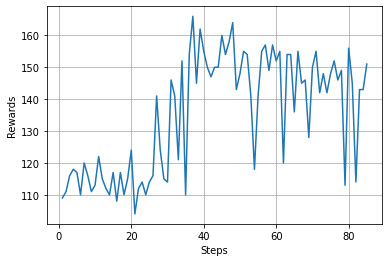

In [ ]:
a = len(goal_steps)
all_prints.step_graph(goal_steps[-a:],len(goal_steps))

In [ ]:
class Custom_Rewards():
  #def __init__(self):
    #self.obs=obs    
    #self.action=action
    #self.reward =reward
  def custom_rew(self,obs,action,reward,new_obs):
    
    self.obs=obs
    self.action = action
    self.reward = reward
    self.new_obs=new_obs
    
    
#if the next action is shooting the ball, the reward will gain 0.2 point ||
#an exo ti mpala kai einai se apostasi x > 0.5 sto gipedo kai exei kanei shout einai kalo    
    if(self.obs[95] == 1 and self.obs[88] > 0.6 and self.action == 12):
      self.reward += 0.02
      #print("EKANE SHOUT MPROSTA APO TO KENTRO ,+0.1")
      return self.reward

    #An kanei shout piso apo to kentro na xanei ligo
    elif(self.obs[95]==1 and self.obs[88] < 0 and self.action == 12):
      self.reward -= 0.02
      #print("EKANE SHOUT PISO APO TO KENTRO, -0.05")
      return self.reward

# if we steal the ball, the reward will gain 0.05 points
    elif self.obs[96] == 1 and self.new_obs[95] == 1:  #obs[96] ball owner right team / obs[95] ball owner left team
        self.reward += 0.05
        #print("PHRE THN MPALA APO TON ANTIPALO , +0.05")
        return self.reward
#if we lose the ball, the reward will lose 0.05 points
    elif self.obs[95] == 1 and self.new_obs[96] == 1:
        self.reward -=0.02
        #print("PHRE THN MPALA O ANTIPALOS , -0.02")
        return self.reward
    else:
      return self.reward


#TODO: if active player far from the ball, the reward will lose by the moving distance

In [ ]:
#print(score_list or reward_list)

In [ ]:

"""print(observation)
new_observation,reward,done,info = env.step(4)
print(new_observation)"""

In [ ]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

In [ ]:
"""env = football_env.create_environment(env_name ='academy_single_goal_versus_lazy',render=False,representation='simple115')
observation =env.reset()
new_observation,reward,done,info = env.step(action)
val=info.values()
print(val)
list_val=list(val)
list_val"""